# **Credit Card Customer churn Analysis - Transform**

## Objectives

* By the end of the extraction phase, I will:
    1. Transform data to extract insights
    2. Answer questions from the "Extract" phase
    3. Validate the answers with statistical tests

## Inputs

* bank_churners_extracted.csv
* Questions to answer:
    1. What variables will help determine/predict attrition probability?
    2. Can customers be grouped for targeted marketing efforts?
    3. Does income impact attrition rates?
    4. What financial habits lead to increased credit card usage?
    5. What financial indicators indicate when a customer is most likely to churn?

## Outputs

* Transformed data
* Validated hypotheses
* Plausible solutions to business the problem - how to avoid further attrition.



---

importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy
import scipy.stats as stats
import plotly.express as px
from scipy.stats import mannwhitneyu

installing plotly, nbformat, and rerunning requirements.txt

In [3]:
pip install plotly 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Transformation

I will re-run a correlation text, but this time, I will convert the categorical variables into numerical variables so I can review how key variables such as income, marital status, education and the liked interact with attrition.

In [5]:
df = pd.read_csv("../data/bank_churners_extracted.csv") #Loading the new dataset
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [6]:
categorical_columns = df.select_dtypes(include="object")
for col in categorical_columns:
   print(f"{col}: {df[col].unique()}")

Attrition_Flag: ['Existing Customer' 'Attrited Customer']
Gender: ['M' 'F']
Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum']


**This encoding taught me tonnes - quite literally.**
1. Using 0 as an ordinal or nominal number could distort values and lower the mean. Using null is an option, however, it might get counted in plots. So, it's better to keep these as np.nan... that way, it's safe for interpretations.

In [7]:
df["mod_Attrition_Flag"] = df["Attrition_Flag"].apply(lambda x: 1 if x =="Attrited Customer" else 0 )
df["mod_Gender"] = df["Gender"].apply(lambda x: 1 if x == "M" else 0)
df["mod_Education_Level"] = df["Education_Level"].replace({"Unknown": np.nan, "Uneducated": 0,  "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5}).infer_objects(copy=False)
df["Marital_Status"] = df["Marital_Status"].replace({"Unknown": np.nan, "Single": 1, "Married": 2, "Divorced": 3}).infer_objects(copy=False)
df["mod_Income_Category"] = df["Income_Category"].replace({"Unknown": np.nan, "Less than $40K": 1, "$40K - $60K": 2, "$60K - $80K": 3, "$80K - $120K": 4, "$120K +": 5}).infer_objects(copy=False)
df["mod_Card_Category"] = df["Card_Category"].replace({"Blue": 0, "Silver": 1, "Gold": 2, "Platinum": 3}).infer_objects(copy=False)
df

C:\Users\mshin\AppData\Local\Temp\ipykernel_37992\3437206724.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["mod_Education_Level"] = df["Education_Level"].replace({"Unknown": np.nan, "Uneducated": 0,  "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5}).infer_objects(copy=False)
C:\Users\mshin\AppData\Local\Temp\ipykernel_37992\3437206724.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Marital_Status"] = df["Marital_Status"].replace({"Unknown": np.nan, "Single": 1, "Married": 2, "Divo

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,mod_Attrition_Flag,mod_Gender,mod_Education_Level,mod_Income_Category,mod_Card_Category
0,768805383,Existing Customer,45,M,3,High School,2.0,$60K - $80K,Blue,39,...,1.335,1144,42,1.625,0.061,0,1,1.0,3.0,0
1,818770008,Existing Customer,49,F,5,Graduate,1.0,Less than $40K,Blue,44,...,1.541,1291,33,3.714,0.105,0,0,3.0,1.0,0
2,713982108,Existing Customer,51,M,3,Graduate,2.0,$80K - $120K,Blue,36,...,2.594,1887,20,2.333,0.000,0,1,3.0,4.0,0
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,1.405,1171,20,2.333,0.760,0,0,1.0,1.0,0
4,709106358,Existing Customer,40,M,3,Uneducated,2.0,$60K - $80K,Blue,21,...,2.175,816,28,2.500,0.000,0,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,1.0,$40K - $60K,Blue,40,...,0.703,15476,117,0.857,0.462,0,1,3.0,2.0,0
10123,710638233,Attrited Customer,41,M,2,Unknown,3.0,$40K - $60K,Blue,25,...,0.804,8764,69,0.683,0.511,1,1,NaN,2.0,0
10124,716506083,Attrited Customer,44,F,1,High School,2.0,Less than $40K,Blue,36,...,0.819,10291,60,0.818,0.000,1,0,1.0,1.0,0
10125,717406983,Attrited Customer,30,M,2,Graduate,NaN,$40K - $60K,Blue,36,...,0.535,8395,62,0.722,0.000,1,1,3.0,2.0,0


**Categorical Variable Encoding Legend**

The following table shows how categorical variables were transformed into numerical values for analysis:

**Variable Encoding Reference:**

| **Variable** | **Original Category** | **Encoded Value** | **Description** |
|--------------|----------------------|-------------------|-----------------|
| **mod_Attrition_Flag** | Existing Customer | 0 | Customer retained |
| | Attrited Customer | 1 | Customer churned |
| **mod_Gender** | F (Female) | 0 | Female customer |
| | M (Male) | 1 | Male customer |
| **mod_Education_Level** | Unknown | NaN | Education level unknown |
| | Uneducated | 1 | No formal education |
| | High School | 2 | High school graduate |
| | College | 3 | College graduate |
| | Graduate | 4 | Graduate degree |
| | Post-Graduate | 5 | Post-graduate degree |
| | Doctorate | 6 | Doctorate degree |
| **Marital_Status** | Unknown | NaN | Marital status unknown |
| | Single | 1 | Single |
| | Married | 2 | Married |
| | Divorced | 3 | Divorced |
| **mod_Income_Category** | Unknown | NaN | Income unknown |
| | Less than $40K | 1 | Low income |
| | $40K - $60K | 2 | Lower-middle income |
| | $60K - $80K | 3 | Middle income |
| | $80K - $120K | 4 | Upper-middle income |
| | $120K + | 5 | High income |
| **mod_Card_Category** | Blue | 0 | Basic card tier |
| | Silver | 1 | Silver card tier |
| | Gold | 2 | Gold card tier |
| | Platinum | 3 | Premium card tier |

### **Encoding Rationale:**

- **Binary variables** (Attrition, Gender): 0/1 encoding for clear interpretation
- **Ordinal variables** (Education, Income, Card): Numerical scale reflecting natural progression/hierarchy
- **Marital Status**: Arbitrary numerical assignment (no inherent order)
- **Missing/Unknown values**: Assigned NaN for 0s

### **Usage Notes:**

**For correlation analysis**: All variables can now be included in numerical correlation matrices  
**For statistical tests**: Enables parametric and non-parametric testing  
**For machine learning**: Ready for algorithms requiring numerical inputs  
**For visualization**: Allows for comprehensive plotting and analysis

In [8]:
df.isna().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level                0
Marital_Status               749
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
mod_Attrition_Flag             0
mod_Gender                     0
mod_Education_Level         1519
mod_Income_Category         1112
mod_Card_Category              0
dtype: int64

In [9]:
(df == 0).sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count              904
Education_Level                0
Marital_Status                 0
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon        29
Contacts_Count_12_mon        399
Credit_Limit                   0
Total_Revolving_Bal         2470
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           5
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            7
Avg_Utilization_Ratio       2470
mod_Attrition_Flag          8500
mod_Gender                  5358
mod_Education_Level         1487
mod_Income_Category            0
mod_Card_Category           9436
dtype: int64

In [12]:
df.to_csv("../data/bank_churners_transformed.csv", index=False)

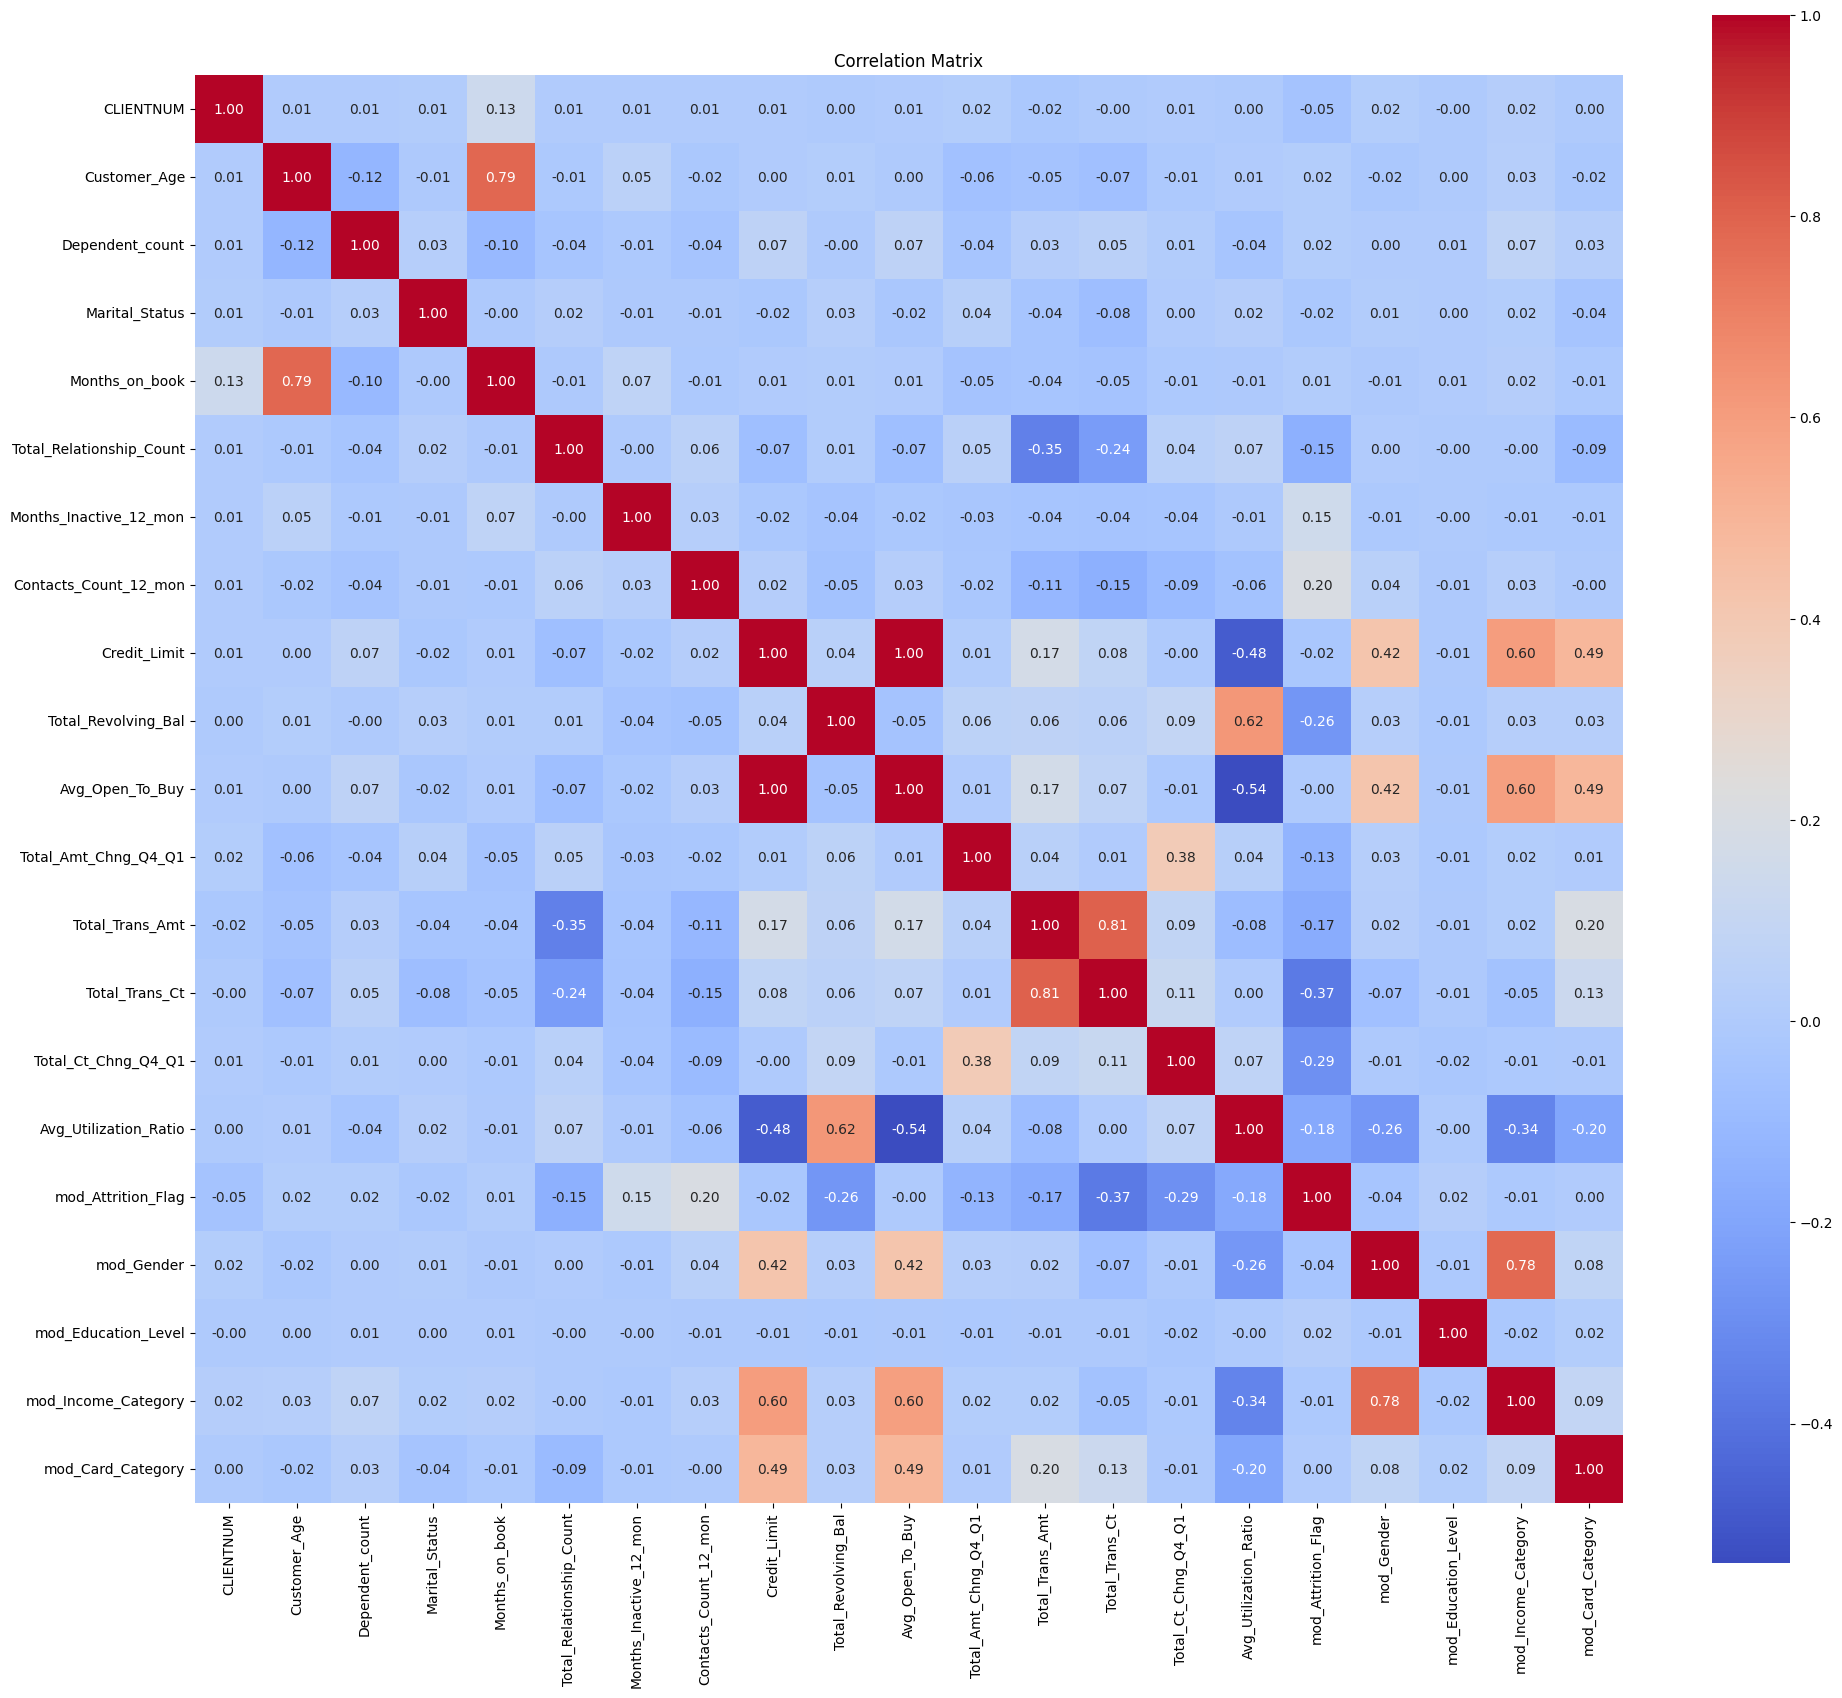

Top 10 highest correlations:
Avg_Open_To_Buy        Credit_Limit             0.995981
Credit_Limit           Avg_Open_To_Buy          0.995981
Total_Trans_Ct         Total_Trans_Amt          0.807192
Total_Trans_Amt        Total_Trans_Ct           0.807192
Months_on_book         Customer_Age             0.788912
Customer_Age           Months_on_book           0.788912
mod_Income_Category    mod_Gender               0.779095
mod_Gender             mod_Income_Category      0.779095
Total_Revolving_Bal    Avg_Utilization_Ratio    0.624022
Avg_Utilization_Ratio  Total_Revolving_Bal      0.624022
dtype: float64

NEGATIVE CORRELATIONS:
Negative correlations (most negative first):
Avg_Open_To_Buy        Avg_Utilization_Ratio   -0.538808
Avg_Utilization_Ratio  Avg_Open_To_Buy         -0.538808
                       Credit_Limit            -0.482965
Credit_Limit           Avg_Utilization_Ratio   -0.482965
Total_Trans_Ct         mod_Attrition_Flag      -0.371403
                                

In [ ]:
numerical_columns = df.select_dtypes(include="number").columns
corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, 
            cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Exclude self-correlations

print("Top 10 highest correlations:")
print(corr_pairs.head(10))

print("\n" + "="*50)
print("NEGATIVE CORRELATIONS:")
print("="*50)

# Get negative correlations sorted from most negative to least negative
negative_corr = corr_pairs[corr_pairs < 0].sort_values(ascending=True)
print("Negative correlations (most negative first):")
print(negative_corr)

**This exercise allows me to pick each category and run statistical tests**

**Correlation Matrix Analysis - Key Findings**

This correlation matrix includes **all numerical variables** plus the **newly encoded categorical variables** (Gender, Education, Marital Status, Income, Card Category). This gives us a comprehensive view of how all factors relate to customer churn.

While attrition doesn't seem to have a positive correlation with any of the variables, we can now run correlation tests and validate key hypotheses.


---

# Does income impact attrition rates?

We can use the modified income category to run a statistical test. Let's begin with the null hypothesis:

**Null Hypothesis**: Income categories and attrition rates are not statitstically linked. Any connection between them is merely random.

In [ ]:
filtered_df = df.dropna(subset=["mod_Income_Category", "mod_Attrition_Flag"])
pg.mwu(x= filtered_df["mod_Income_Category"], y=filtered_df["mod_Attrition_Flag"])

,U-val,alternative,p-val,RBC,CLES
MWU,78706305.0,two-sided,0.0,0.936904,0.968452


A p-val score of 0.0 provides strong evidence to reject the null hypothesis, suggesting a statistically significant associateion between Income and Attrition Flag.

In [ ]:
filtered = df.dropna(subset=["mod_Income_Category", "mod_Attrition_Flag"])

group0 = filtered[filtered["mod_Attrition_Flag"] == 0]["mod_Income_Category"]
group1 = filtered[filtered["mod_Attrition_Flag"] == 1]["mod_Income_Category"]

stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
print(f"MWU U-Value: {stat}, p-Value: {p}")

MWU U-Value: 5593680.0, p-Value: 0.10795399349384172


In [ ]:
print("group0 (retained):", len(group0))
print("group1 (attrited):", len(group1))

group0 (retained): 7575
group1 (attrited): 1440


In [ ]:
plot_df = df.dropna(subset=["mod_Income_Category", "mod_Attrition_Flag"]).copy()

plot_df["Attrition_Label"] = plot_df["mod_Attrition_Flag"].map({0: "Retained", 1: "Attrited"})

plt.figure(figsize=(8, 6))
fig = px.box(
    plot_df,
    x="Attrition_Label",
    y="mod_Income_Category",
    points="all",  # show all points for visibility
    color="Attrition_Label",
    title="Income Category Distribution by Attrition Status",
    labels={
        "Attrition_Label": "Customer Attrition Status",
        "mod_Income_Category": "Income Category (Ordinal)"
    },
    width=800,
    height=500
)

fig.update_traces(marker=dict(opacity=0.4, size=5), jitter=0.3)
fig.update_layout(showlegend=False)
fig.show()

<Figure size 800x600 with 0 Axes>

The boxplot shows that attrited customers are mostly in lower income categories (1–4), with less spread. Retained customers have more income diversity. While income is not perfectly correlated with attrition, it’s clearly an important feature worth monitoring.

We need to design solutions that are low income group-friendly. 

**Questions we need answered:**
1. What variables will help determine/predict attrition probability?
2. Can customers be grouped for targeted marketing efforts?
3. Does income impact attrition rates?
4. What financial habits lead to increased credit card usage?
5. What financial indicators indicate when a customer is most likely to churn?
